<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Transforming Excel Analysis into pandas Data Models</h1>
<h1>Simple Data Modeling</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import sklearn
from sklearn.linear_model import LinearRegression

import scipy
from scipy.optimize import curve_fit

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: cf1f9e0456cec9d5d960512c3269cc904d79928a

pandas    : 1.1.3
numpy     : 1.19.2
scipy     : 1.5.2
watermark : 2.1.0
json      : 2.0.9
sklearn   : 0.23.2
matplotlib: 3.3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Windowing

We start by loading the AAPL stock dataset

In [4]:
data = pd.read_csv('data/AAPL.csv', parse_dates=['Date'], index_col=0)

We can generate a 7 day running average of the values using __rolling__

In [5]:
data.rolling(7).mean().dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-22,0.489477,0.491071,0.488839,0.488839,0.387327,3.559040e+07
1980-12-23,0.494898,0.496492,0.494260,0.494260,0.391622,2.051600e+07
1980-12-24,0.507972,0.509885,0.507653,0.507653,0.402234,1.594880e+07
1980-12-26,0.533801,0.536033,0.533801,0.533801,0.422952,1.415760e+07
1980-12-29,0.559630,0.561862,0.559630,0.559630,0.443417,1.439760e+07
...,...,...,...,...,...,...
2020-02-24,317.542855,320.828574,314.107143,317.709996,317.709996,3.120327e+07
2020-02-25,314.222857,317.444288,308.790000,312.454280,312.454280,3.605777e+07
2020-02-26,308.764287,313.430001,303.597142,307.839992,307.839992,4.026996e+07


We can compare the original and the smoothed values using a quick plot. For clarity we use only the values from 2016 onwards

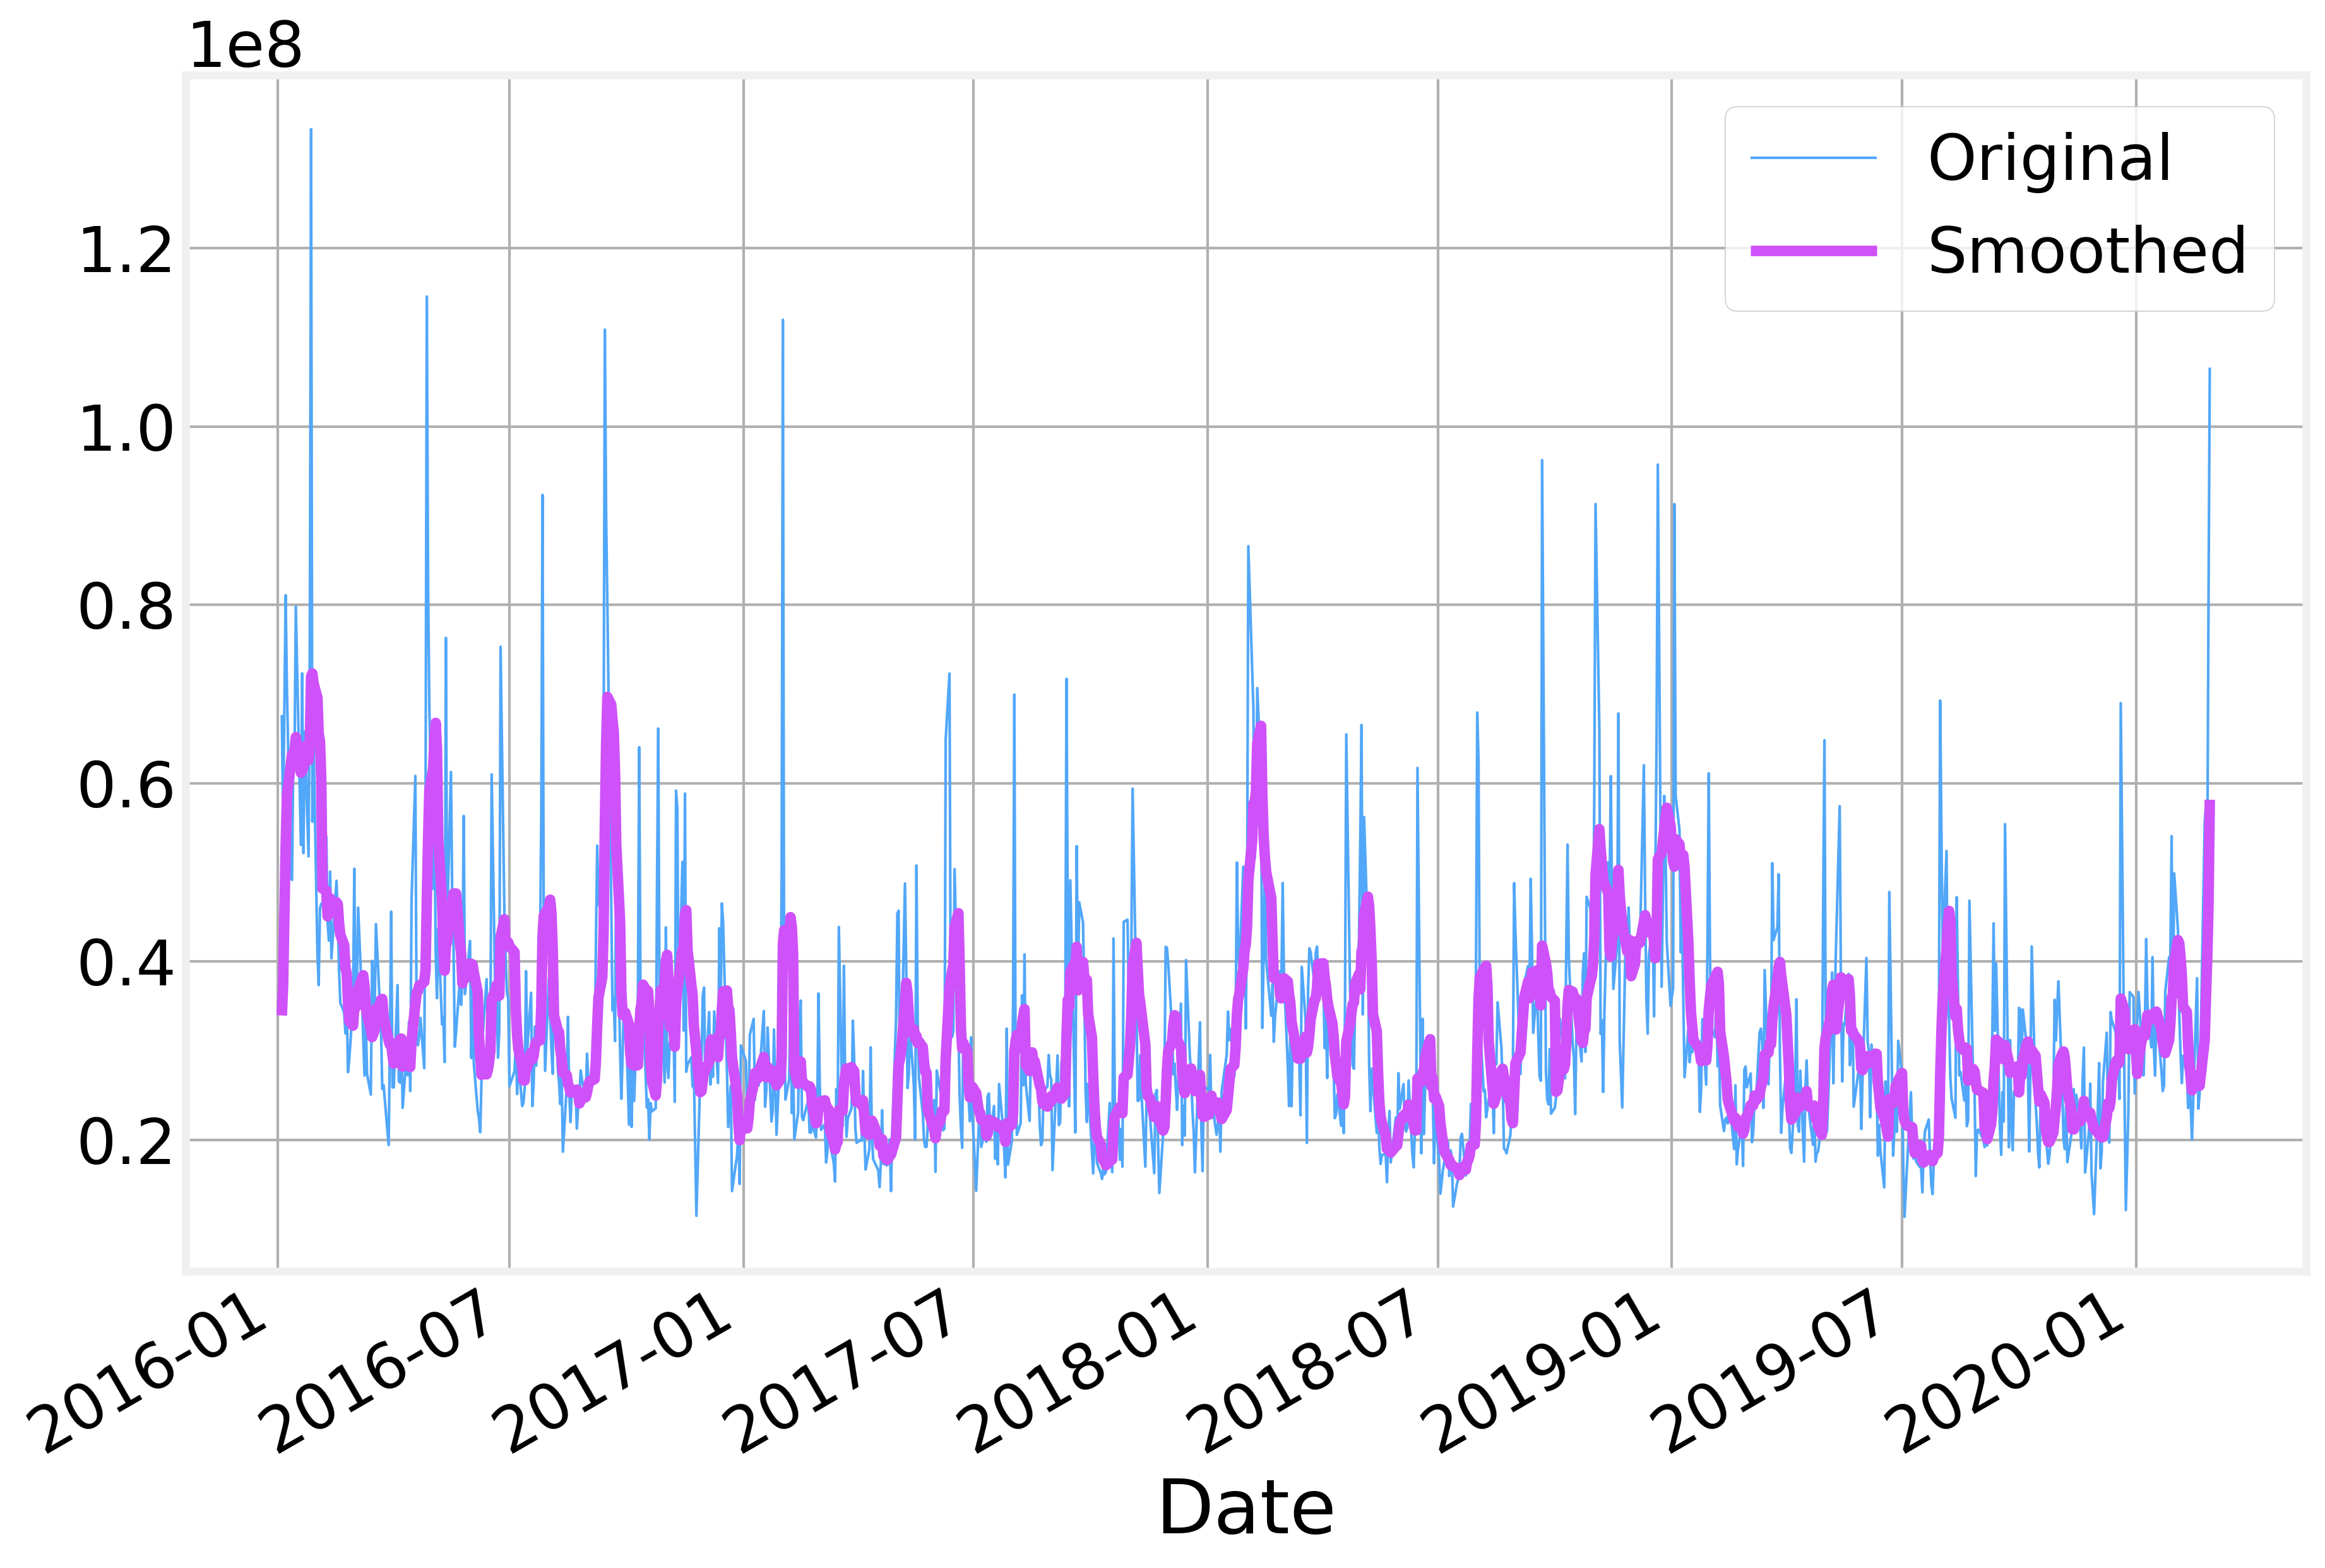

In [6]:
ax = data['2016':].plot(y='Volume', lw=1)
data.rolling(7).mean().dropna()['2016':].plot(y='Volume', ax=ax)
ax.legend(['Original', 'Smoothed'])

As rolling returns an array like object we can easily daisy chain other operations. To get the envelope of the variations, we can do

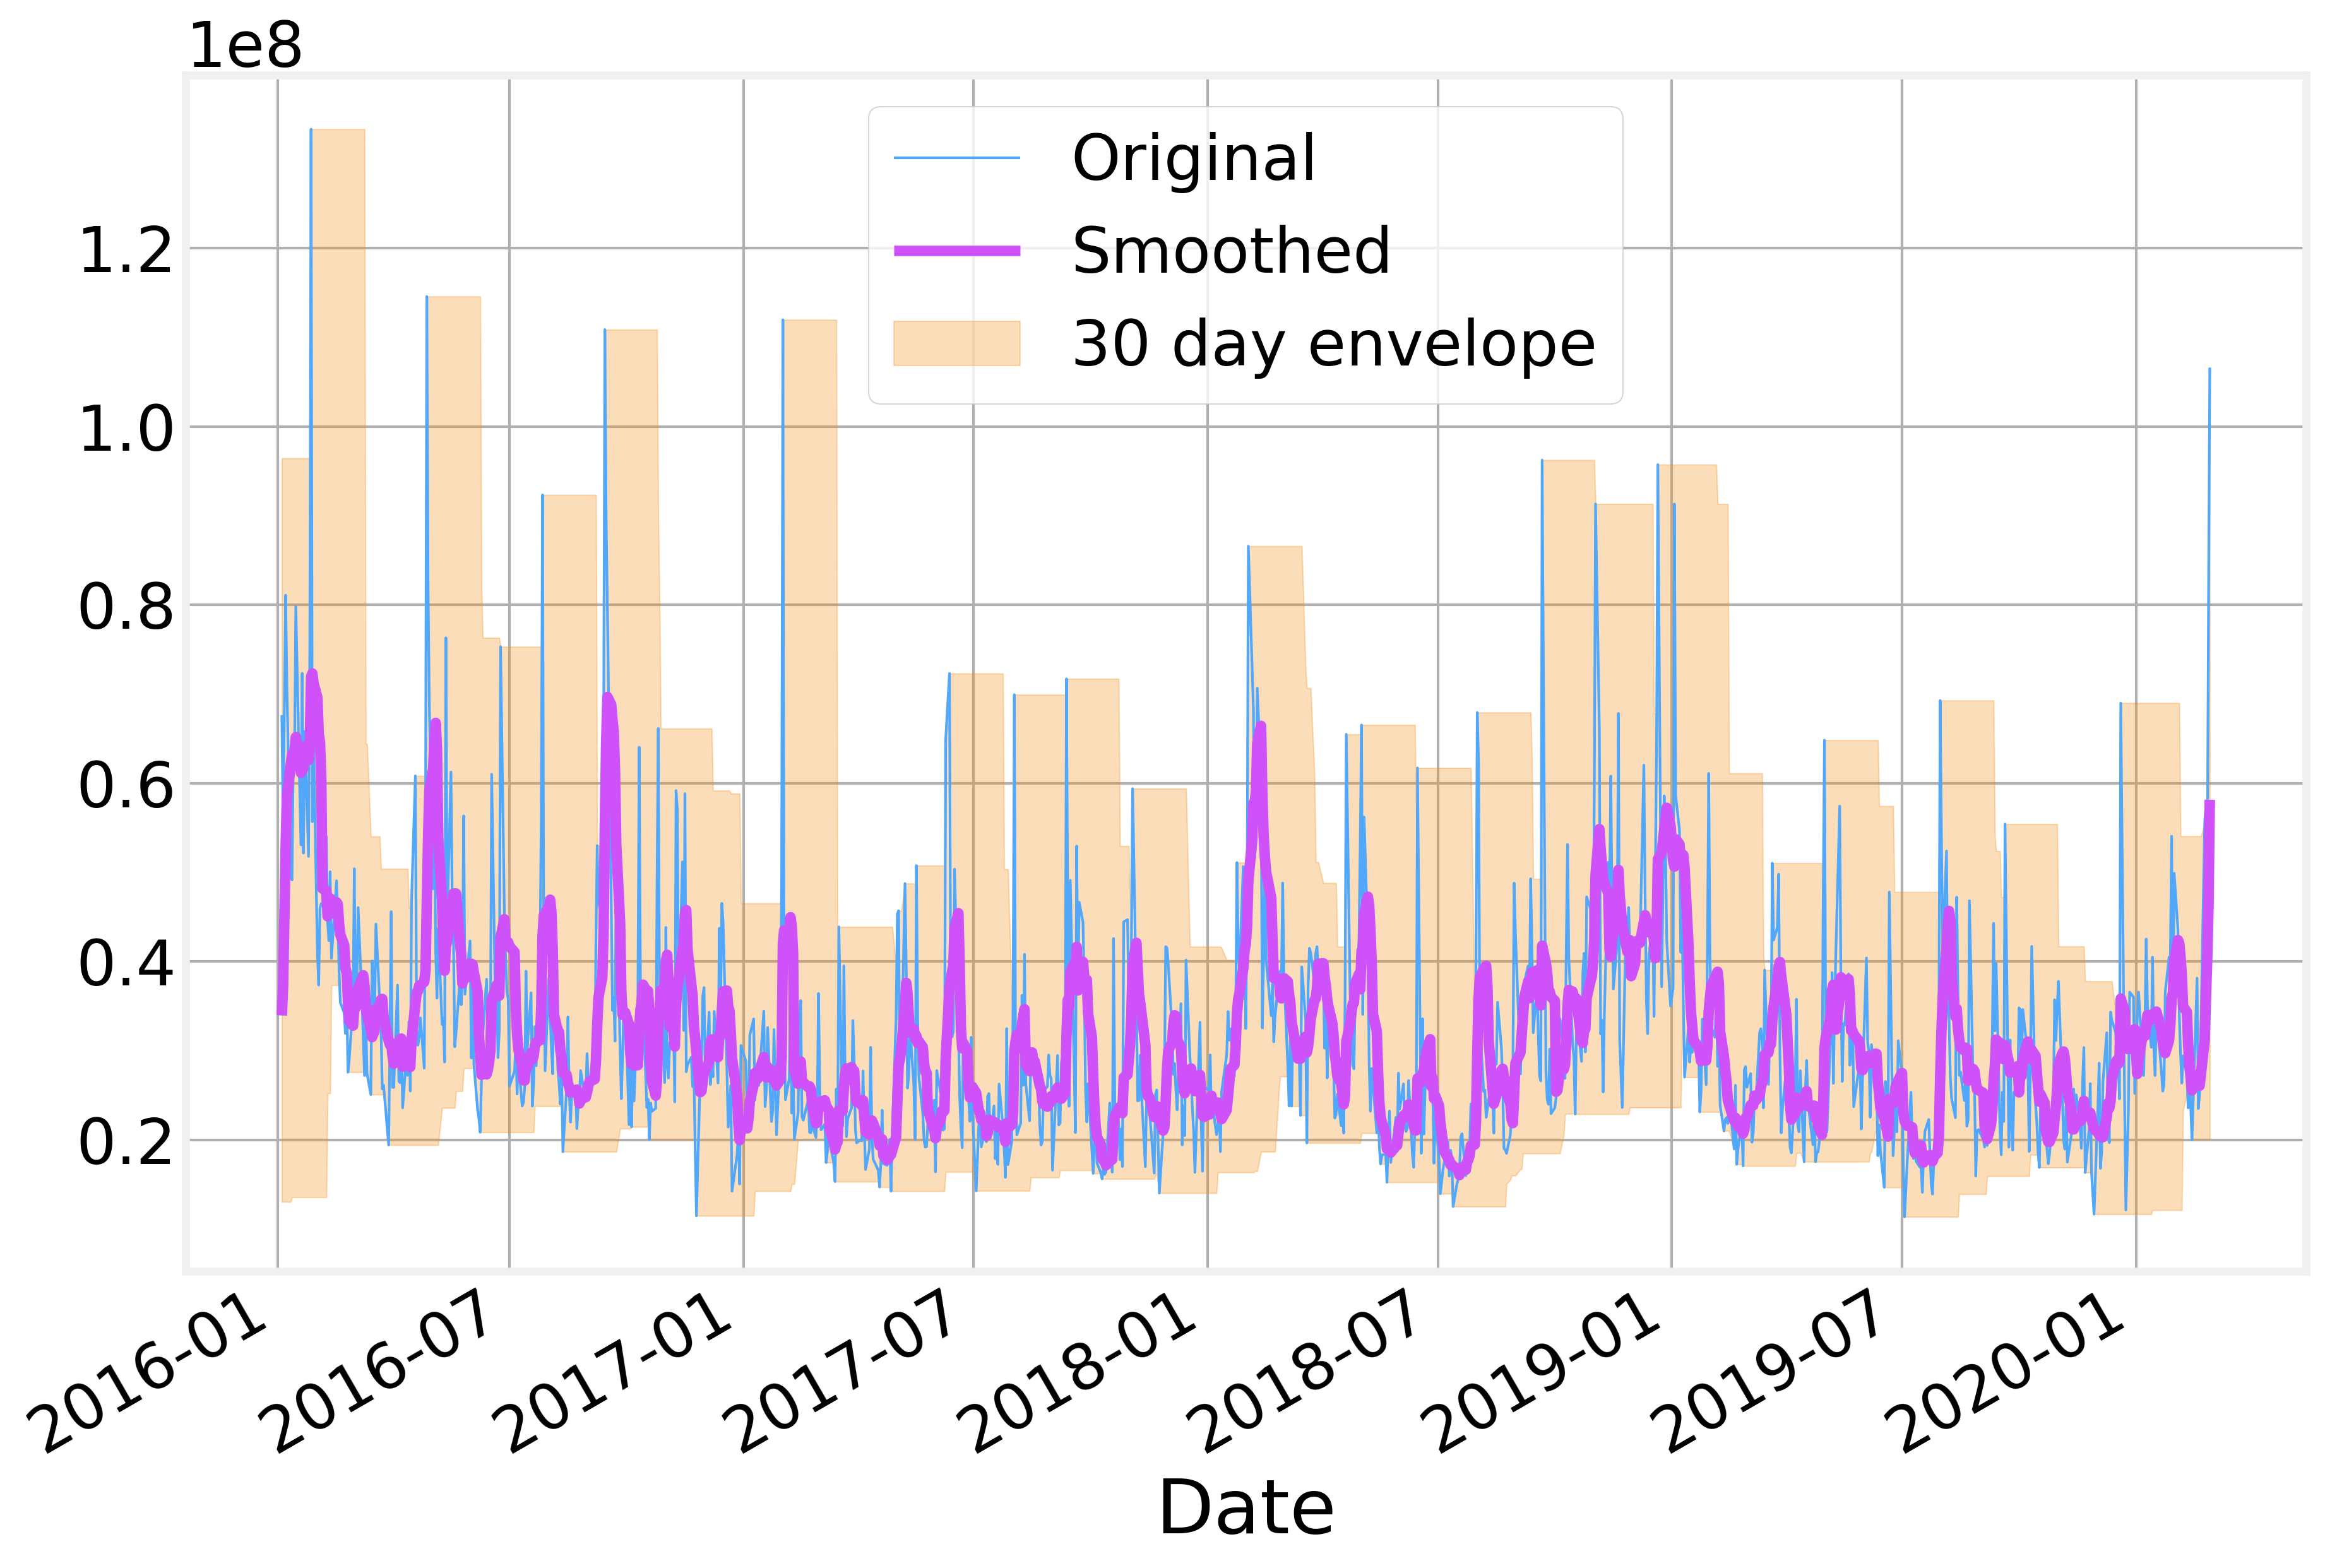

In [7]:
upper_limit = data.rolling(30).max().dropna()['2016':]
lower_limit = data.rolling(30).min().dropna()['2016':]

ax = data['2016':].plot(y='Volume', lw=1)
data.rolling(7).mean().dropna()['2016':].plot(y='Volume', ax=ax)
ax.fill_between(x=data['2016':].index, y1=upper_limit['Volume'], y2=lower_limit['Volume'], color=colors[3], alpha=0.3)
ax.legend(['Original', 'Smoothed', '30 day envelope'])

## GroupBy

We start by loading the movies Excel file

In [8]:
df = pd.read_excel('data/movies.xlsx', index_col='Title')

In [9]:
df.head()

,Year,Genres,Language,Country,Content Rating,Duration,Aspect Ratio,Budget,Gross Earnings,Director,...,Facebook Likes - Actor 1,Facebook Likes - Actor 2,Facebook Likes - Actor 3,Facebook Likes - cast Total,Facebook likes - Movie,Facenumber in posters,User Votes,Reviews by Users,Reviews by Crtiics,IMDB Score
Title,,,,,,,,,,,,,,,,,,,,,
Intolerance: Love's Struggle Throughout the Ages,1916,Drama|History|War,NaN,USA,Not Rated,123,1.33,385907.0,NaN,D.W. Griffith,...,436,22,9.0,481,691,1,10718,88,69.0,8.0
Over the Hill to the Poorhouse,1920,Crime|Drama,NaN,USA,NaN,110,1.33,100000.0,3000000.0,Harry F. Millarde,...,2,2,0.0,4,0,1,5,1,1.0,4.8
The Big Parade,1925,Drama|Romance|War,NaN,USA,Not Rated,151,1.33,245000.0,NaN,King Vidor,...,81,12,6.0,108,226,0,4849,45,48.0,8.3
Metropolis,1927,Drama|Sci-Fi,German,Germany,Not Rated,145,1.33,6000000.0,26435.0,Fritz Lang,...,136,23,18.0,203,12000,1,111841,413,260.0,8.3
Pandora's Box,1929,Crime|Drama|Romance,German,Germany,Not Rated,110,1.33,NaN,9950.0,Georg Wilhelm Pabst,...,426,20,3.0,455,926,1,7431,84,71.0,8.0


groupby gives us a simple way to aggregate values based on the entries of a specific column to generate summary statistics, etc

In [10]:
df[['Year', 'Language']].groupby('Year').count()

,Language
Year,
1916,0
1920,0
1925,0
1927,1
1929,2
...,...
1995,70
1996,99
1997,118


Total budget

In [11]:
df[['Budget', 'Year']].groupby('Year').sum()

,Budget
Year,
1916,3.859070e+05
1920,1.000000e+05
1925,2.450000e+05
1927,6.000000e+06
1929,3.790000e+05
...,...
1995,2.195925e+09
1996,3.098820e+09
1997,6.417845e+09


etc

## Pivot Tables

Pivot tables are a particularly powerful way to manipulate a DataFrame to generate summary tables of values. For example, we can easily slice our data to create time series of the average budget for each year in our dataset

In [12]:
pd.pivot_table(df, index='Year', values='Budget', aggfunc=np.mean)

,Budget
Year,
1916,3.859070e+05
1920,1.000000e+05
1925,2.450000e+05
1927,6.000000e+06
1929,3.790000e+05
...,...
1995,3.277500e+07
1996,3.162061e+07
1997,5.942449e+07


And also by director. For simplicity, we'll focus just on movies from 1995 onwards

In [13]:
pd.pivot_table(df[df['Year']>=1995], index='Year', columns="Director", values='Budget', aggfunc=np.mean)

Director,Abel Ferrara,Adam Rifkin,Alan Cohn,Alan J. Pakula,Alan Parker,Alan Rudolph,Alan Shapiro,Albert Brooks,Alex Proyas,Alex Zamm,...,Vincenzo Natali,Walter Salles,Warren Beatty,Wayne Wang,Wes Anderson,Wes Craven,William Friedkin,William Malone,Wolfgang Petersen,Woody Allen
Year,,,,,,,,,,,,,,,,,,,,,
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20000000.0,50000000.0,NaN,50000000.0,NaN
1996,12500000.0,NaN,NaN,NaN,55000000.0,NaN,25530000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7000000.0,15000000.0,NaN,NaN,NaN,20000000.0
1997,NaN,NaN,NaN,86000000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,365000.0,NaN,NaN,NaN,NaN,24000000.0,NaN,NaN,85000000.0,20000000.0
1998,NaN,NaN,14000000.0,NaN,NaN,NaN,NaN,NaN,27000000.0,10000000.0,...,NaN,2900000.0,30000000.0,NaN,9000000.0,NaN,NaN,NaN,NaN,12000000.0
1999,NaN,15000000.0,NaN,NaN,25000000.0,12000000.0,NaN,15000000.0,NaN,NaN,...,NaN,NaN,NaN,23000000.0,NaN,NaN,NaN,19000000.0,NaN,NaN


Years where a director didn't create any movies have NaN as a place holder budget

## Basic Plotting

For plotting, we will focus on the APPL dataset.

In [14]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400.0


We can generate a simple plot of the Volume as a function of time

<AxesSubplot:xlabel='Date'>

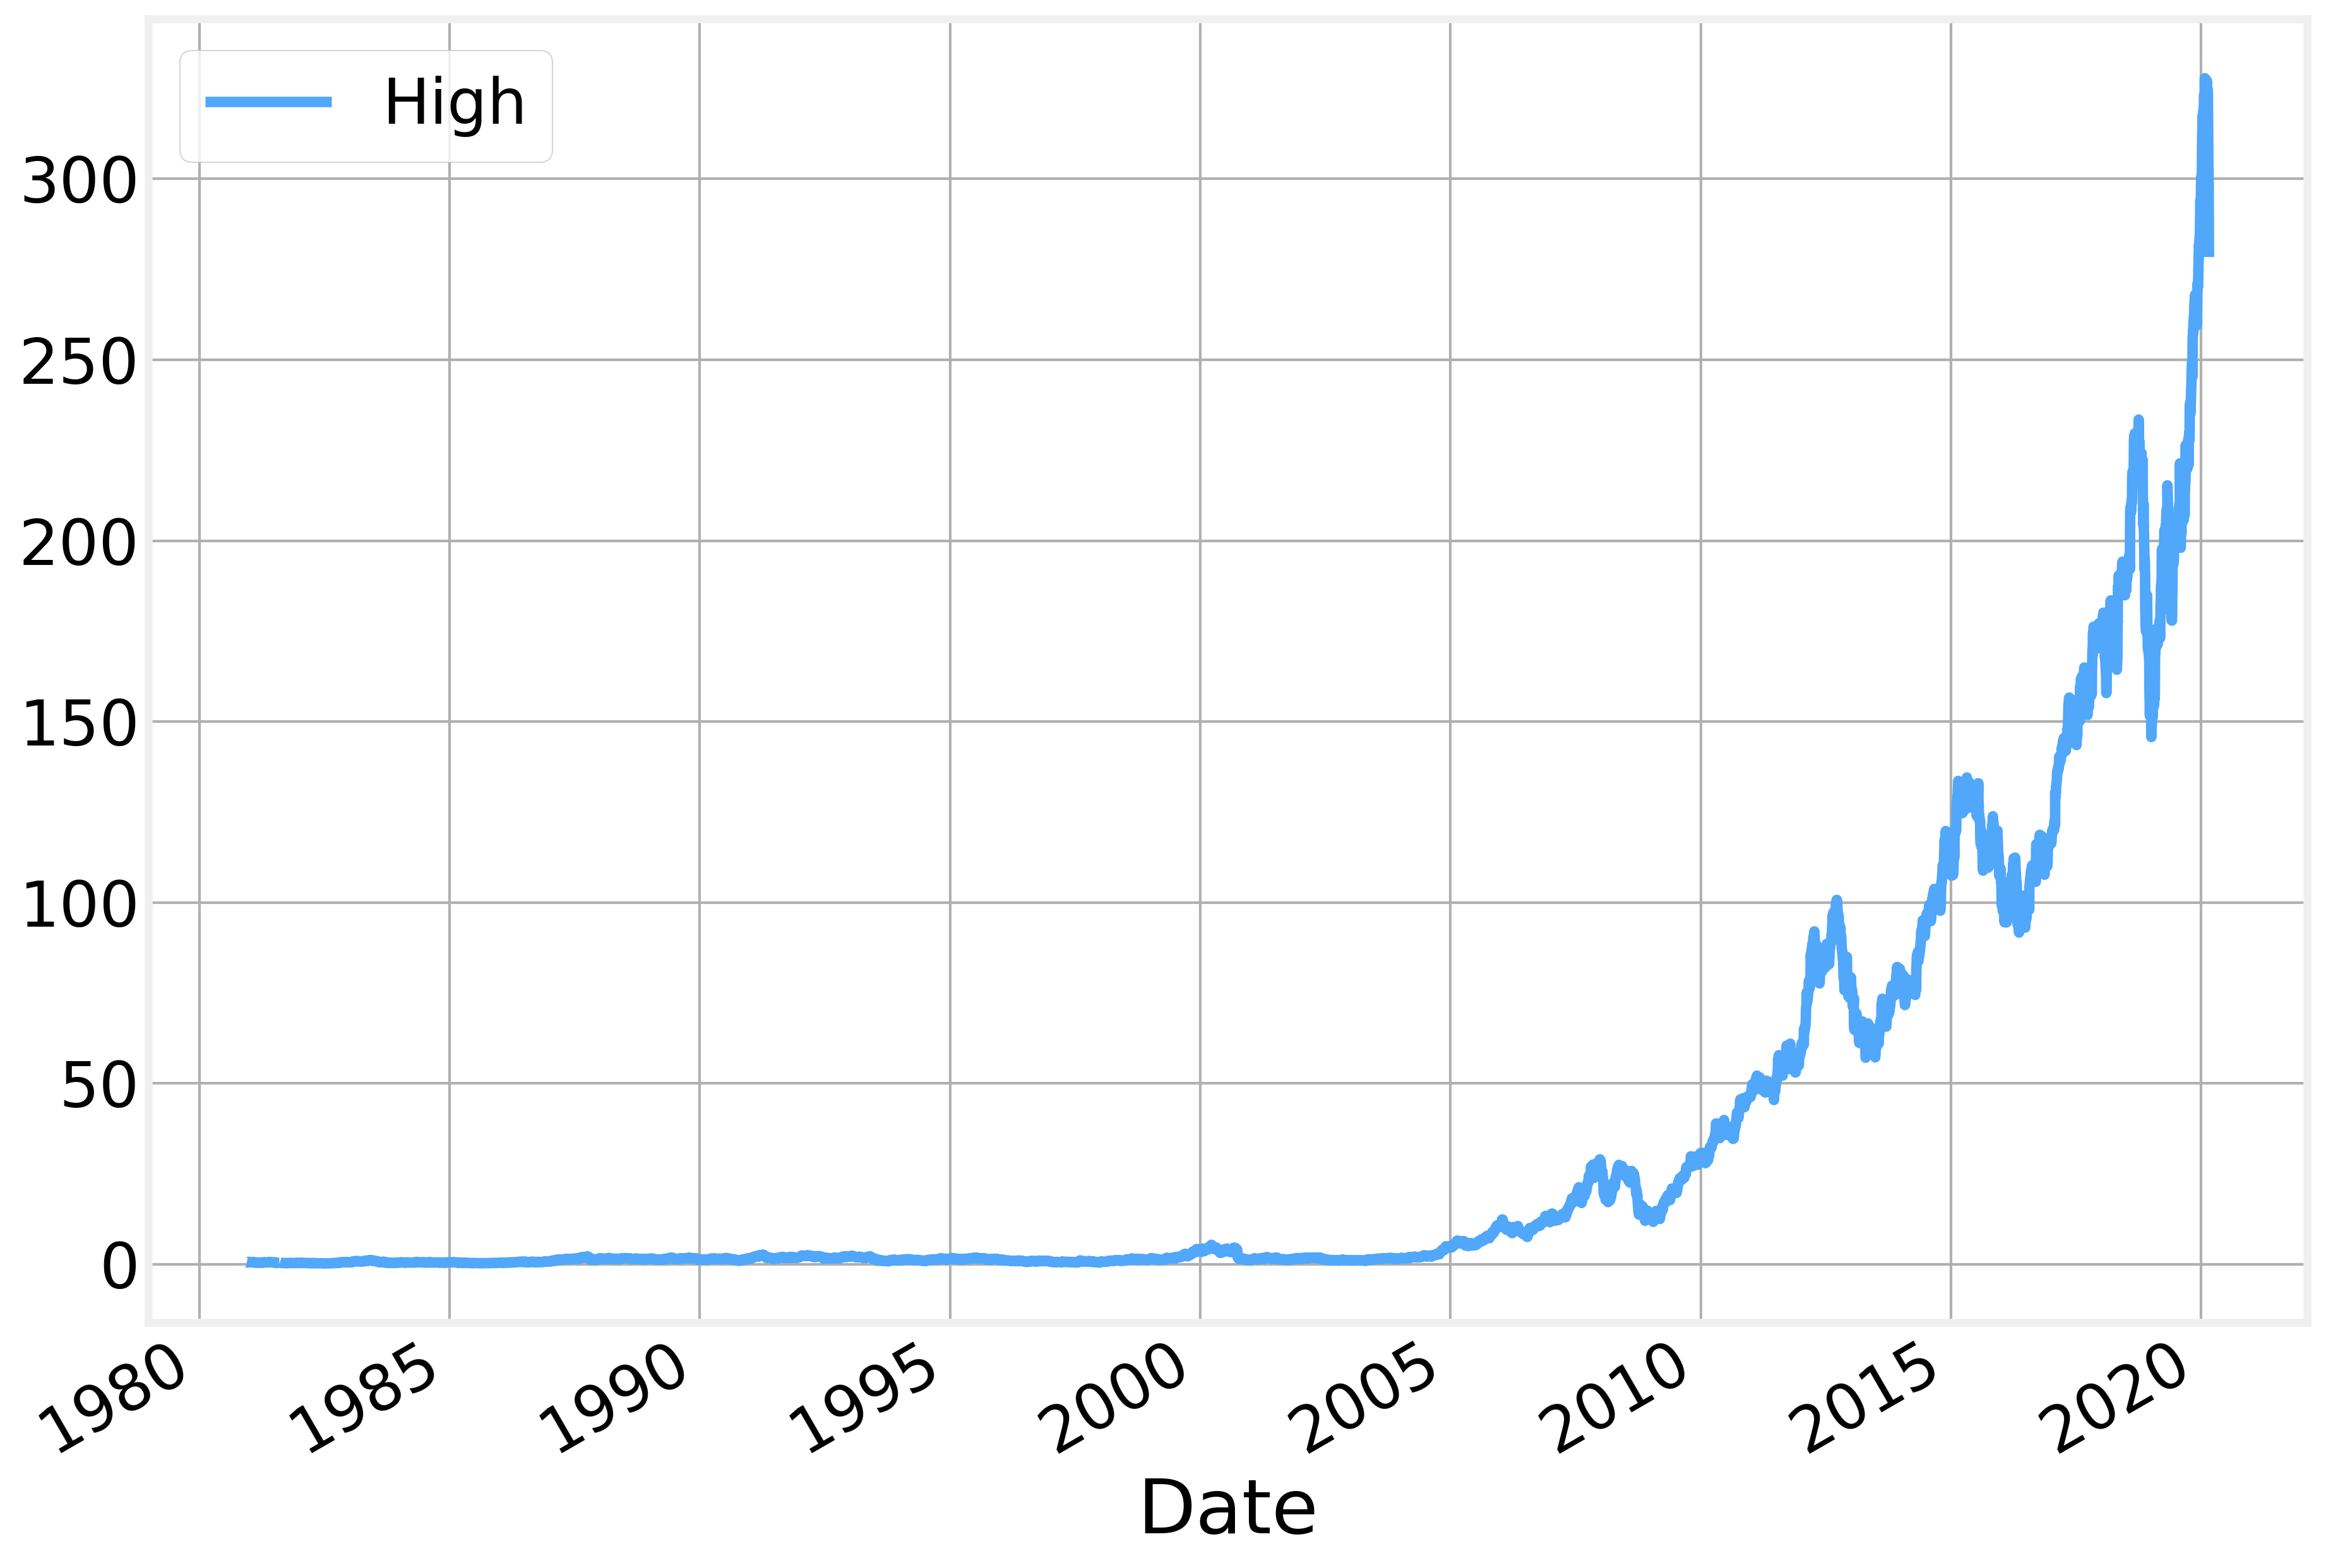

In [15]:
data.plot(y='High')

Bar plots to display categorical variables are also easy

<AxesSubplot:xlabel='Title'>

/Users/bgoncalves/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


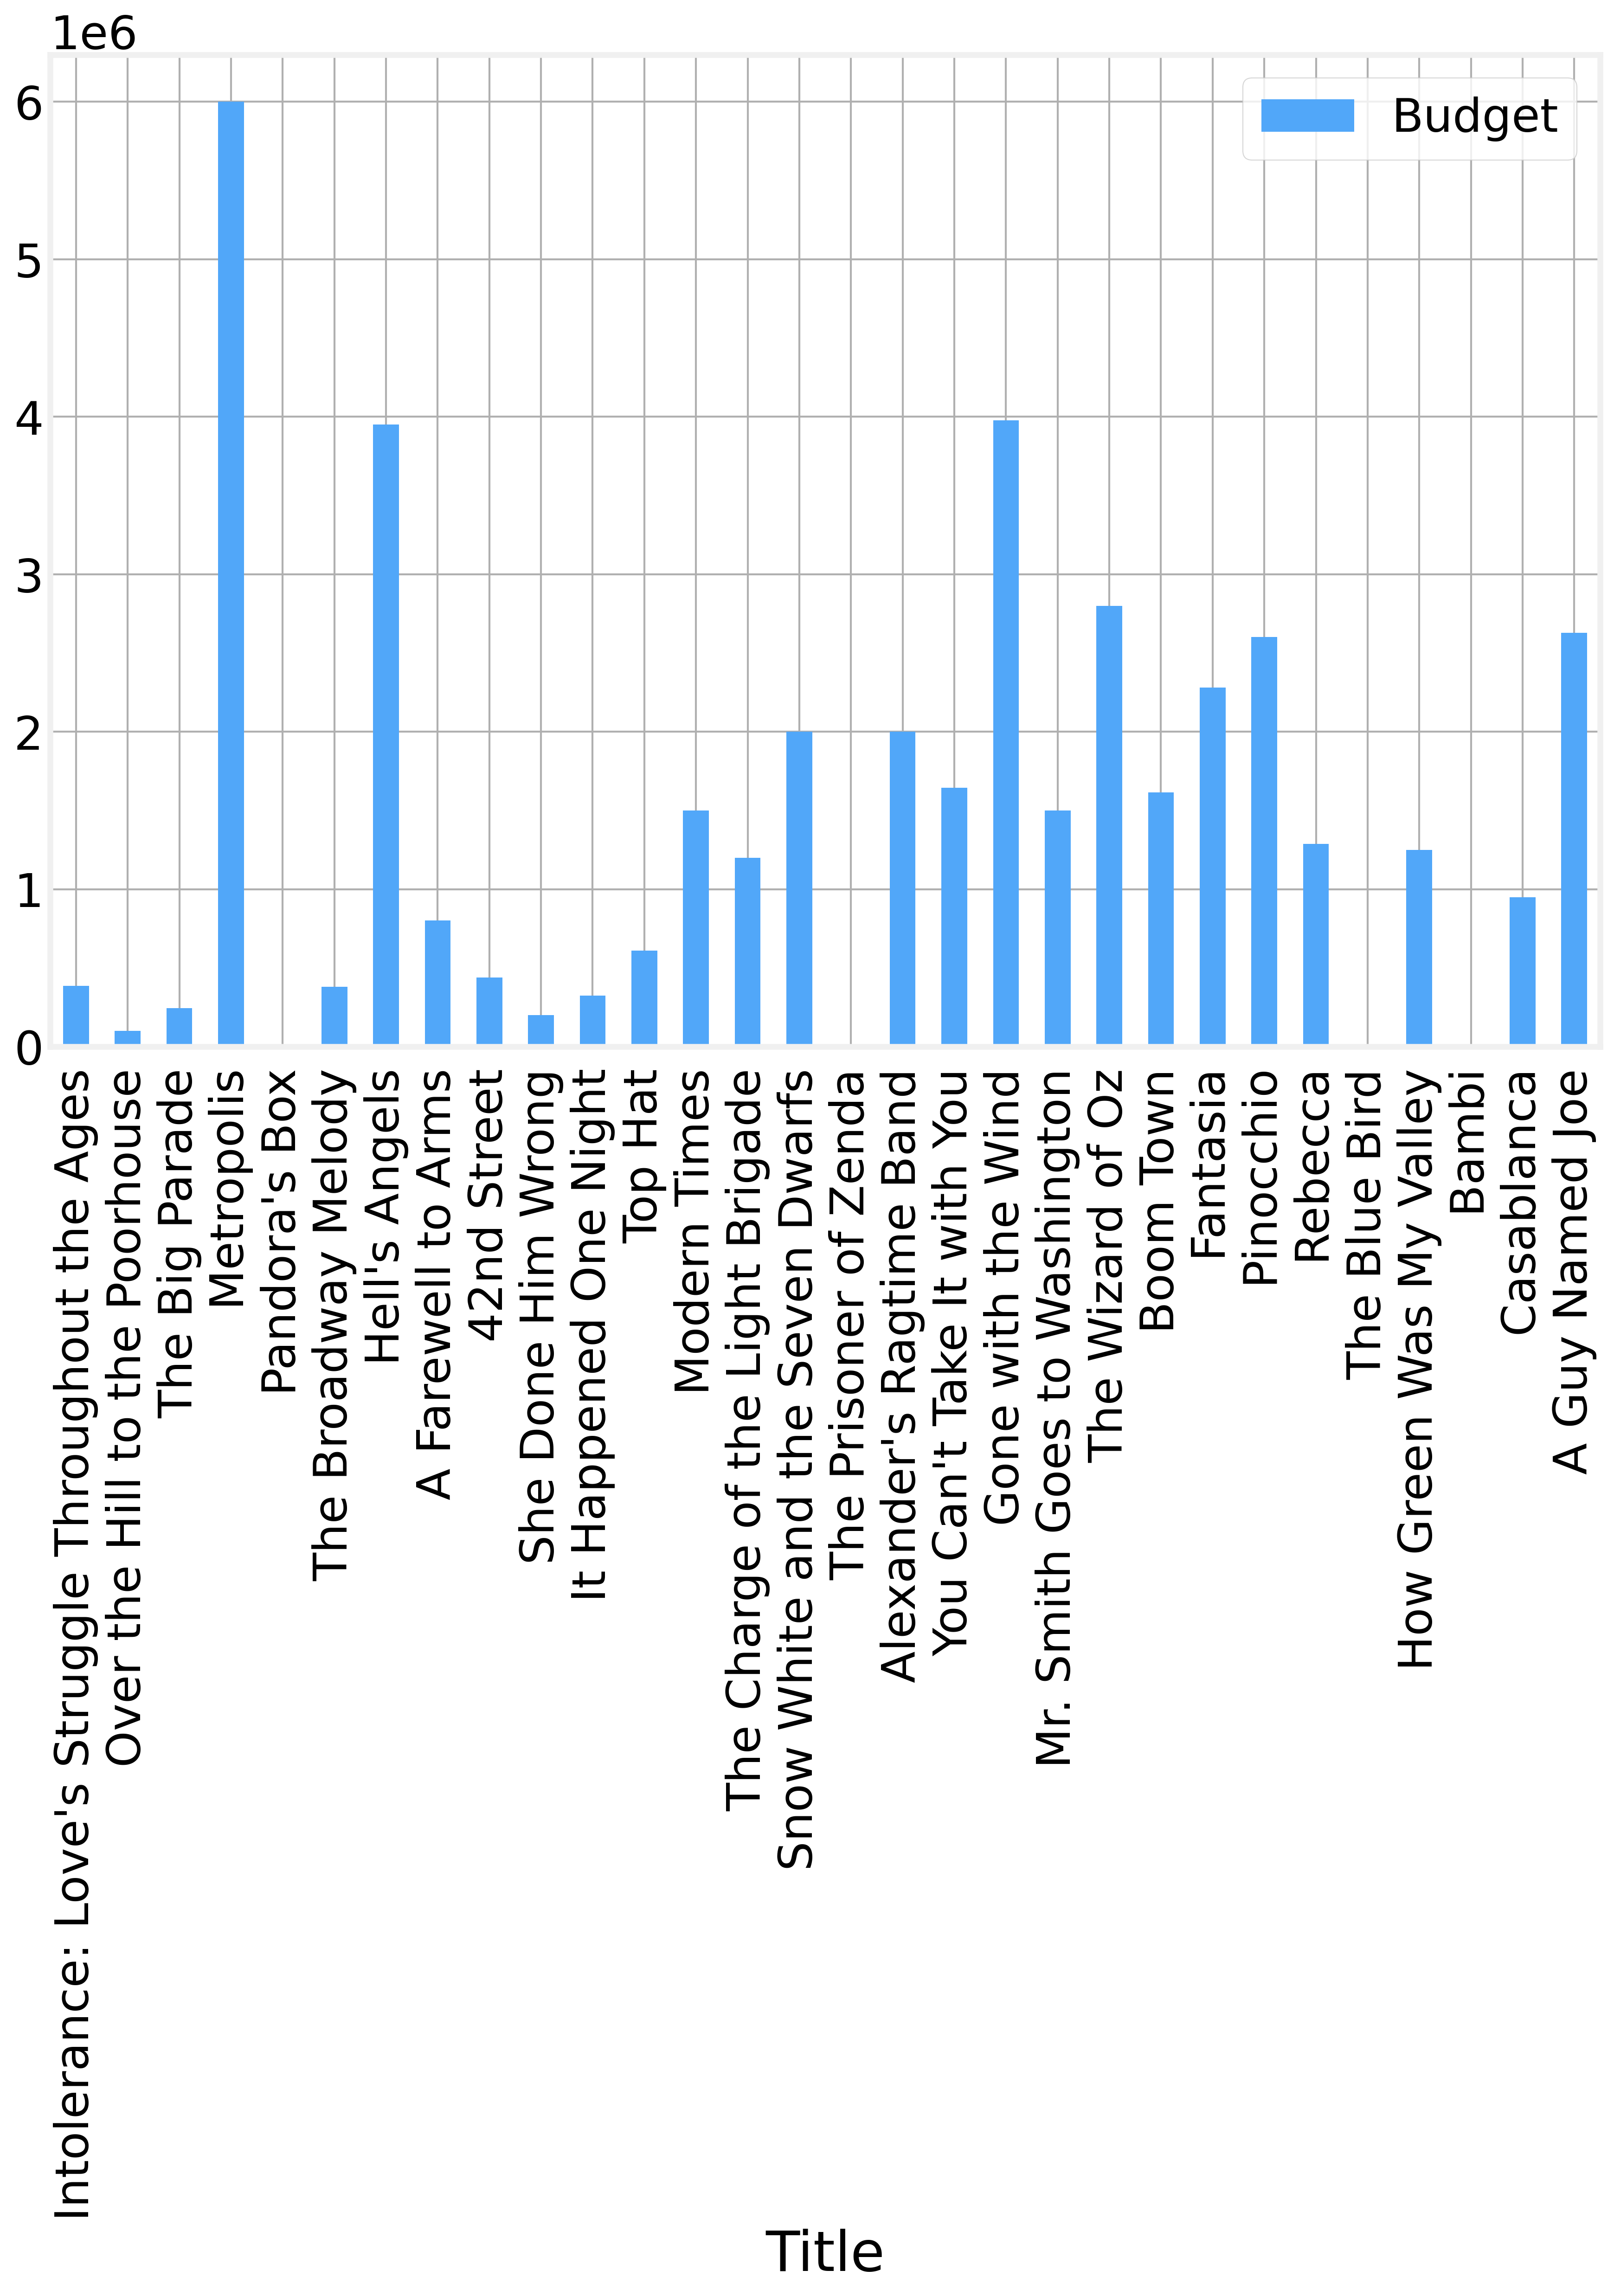

In [16]:
df.iloc[:30].plot.bar(y='Budget')

For clarity, we plot just the first 30 titles

Pandas returns a matplotlib object that can be further manipulated, to create a more sophisticated plot

<AxesSubplot:xlabel='Date'>

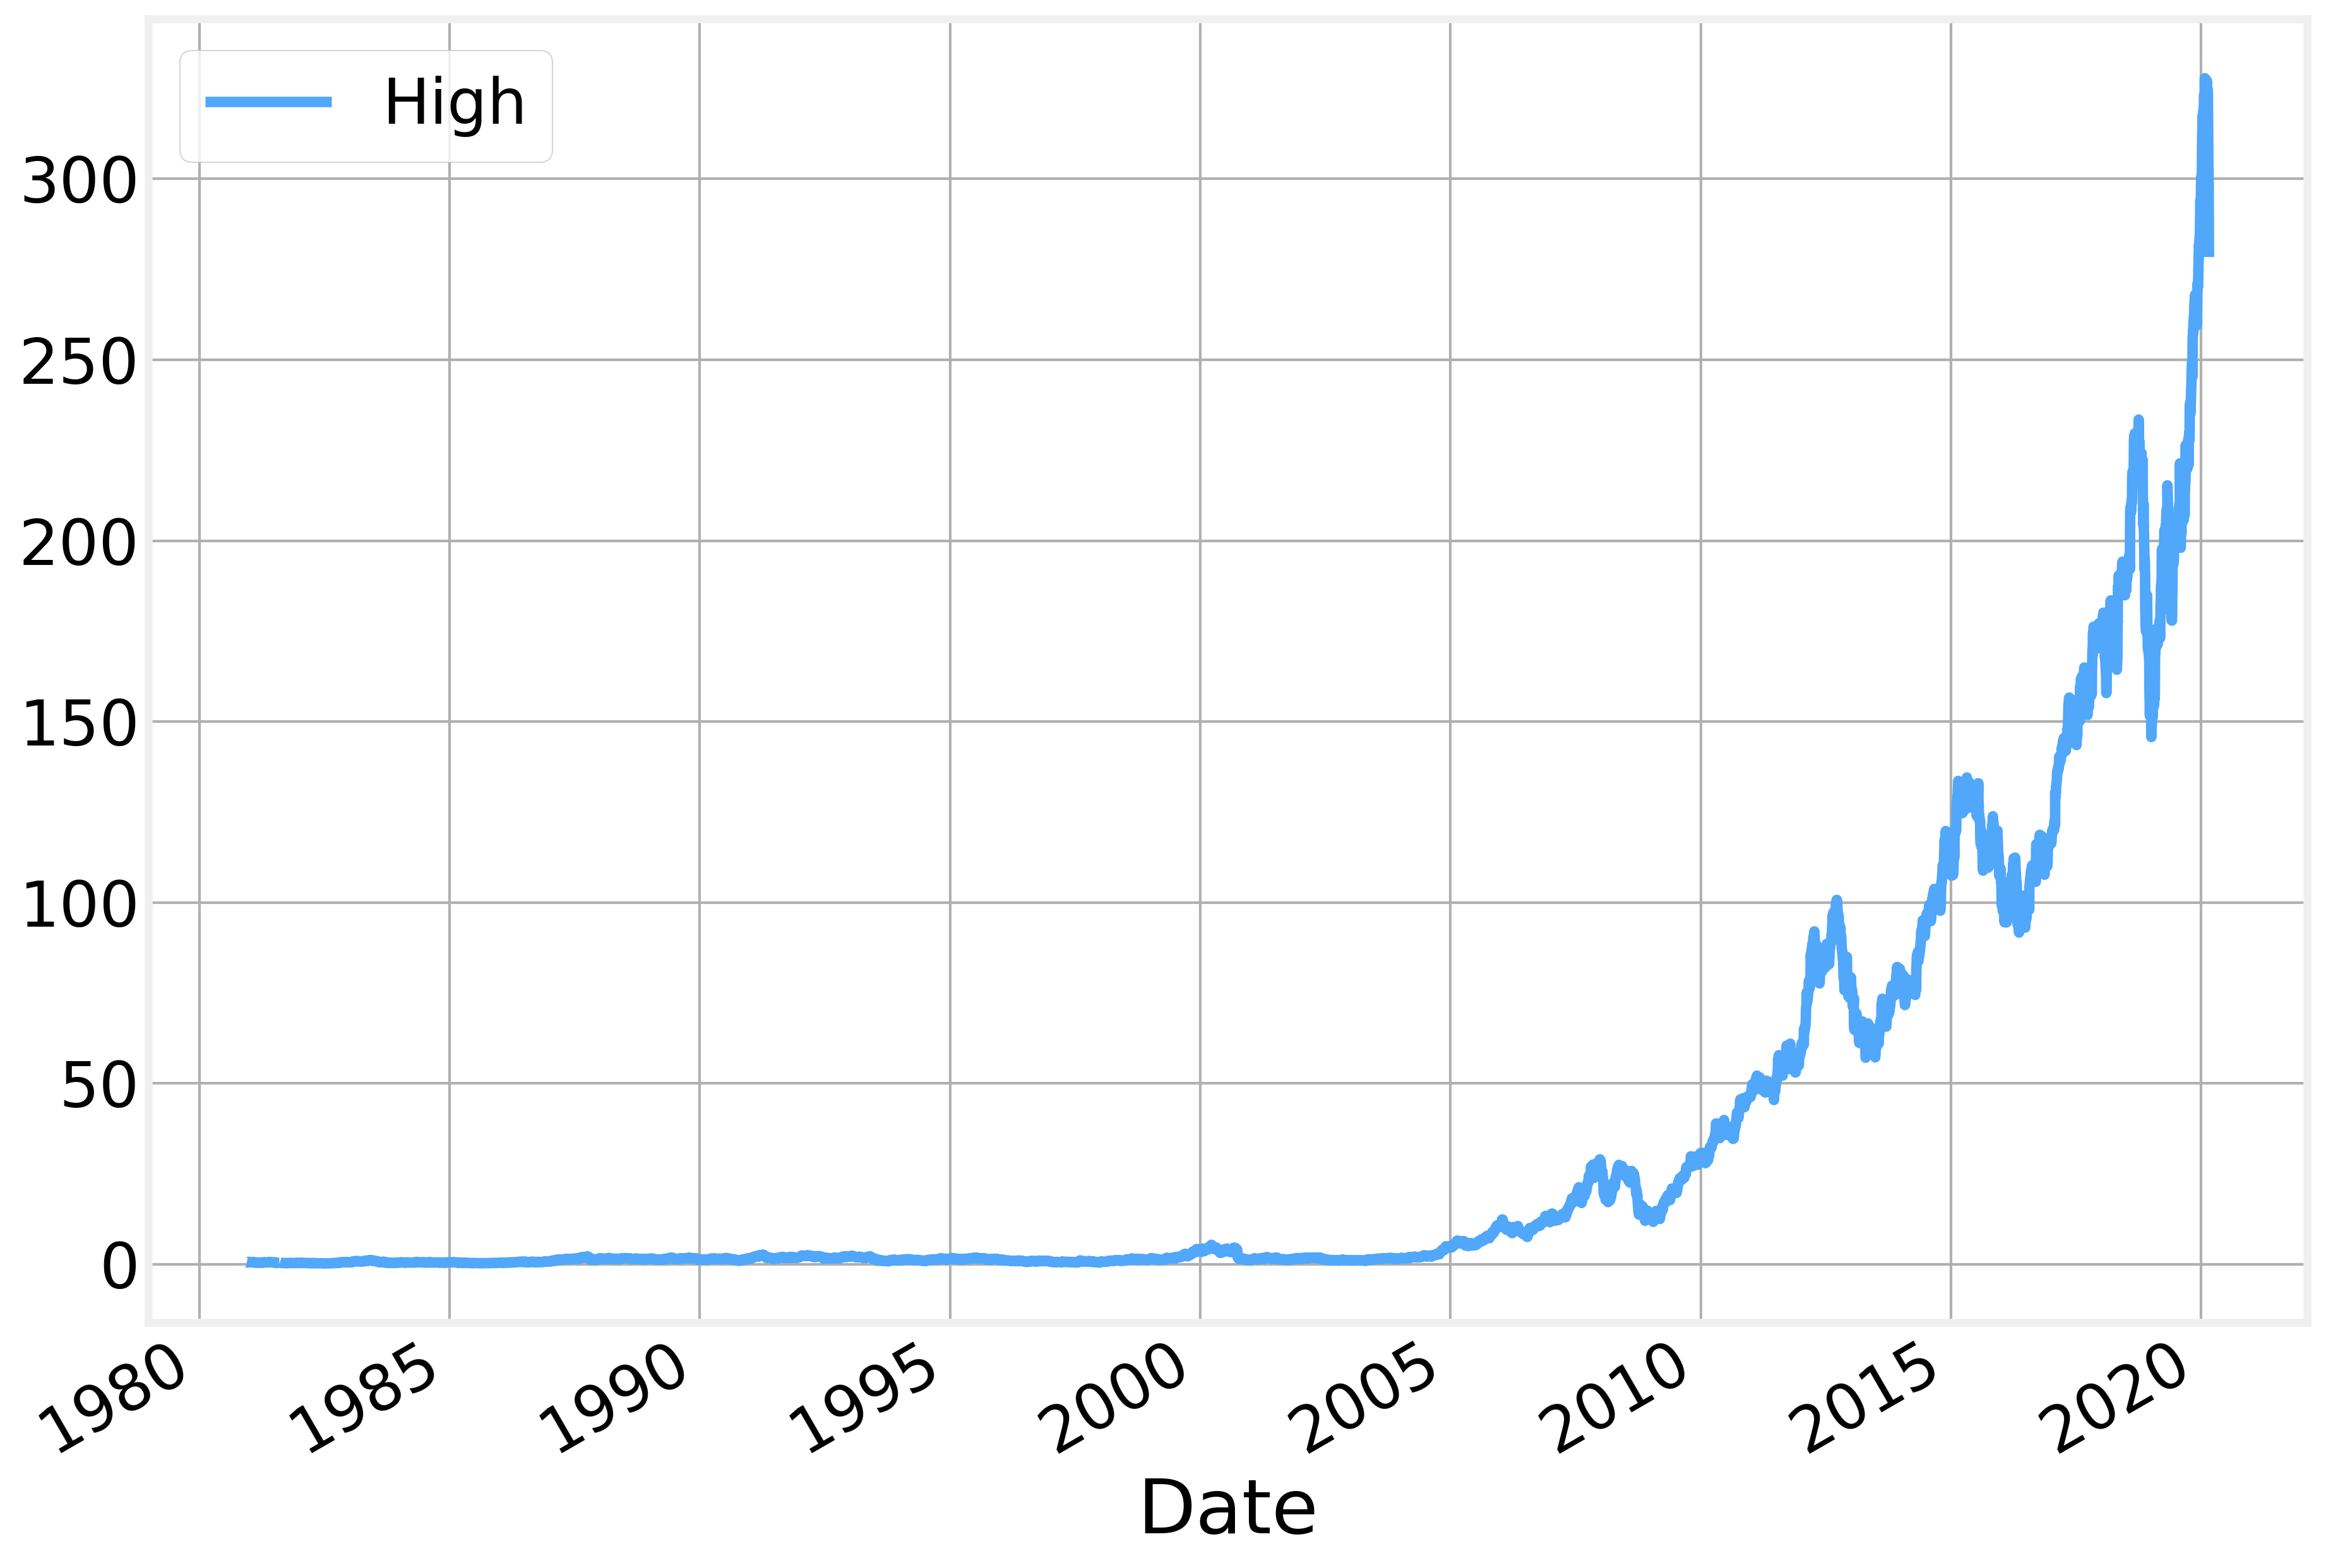

In [17]:
data.plot(y='High')

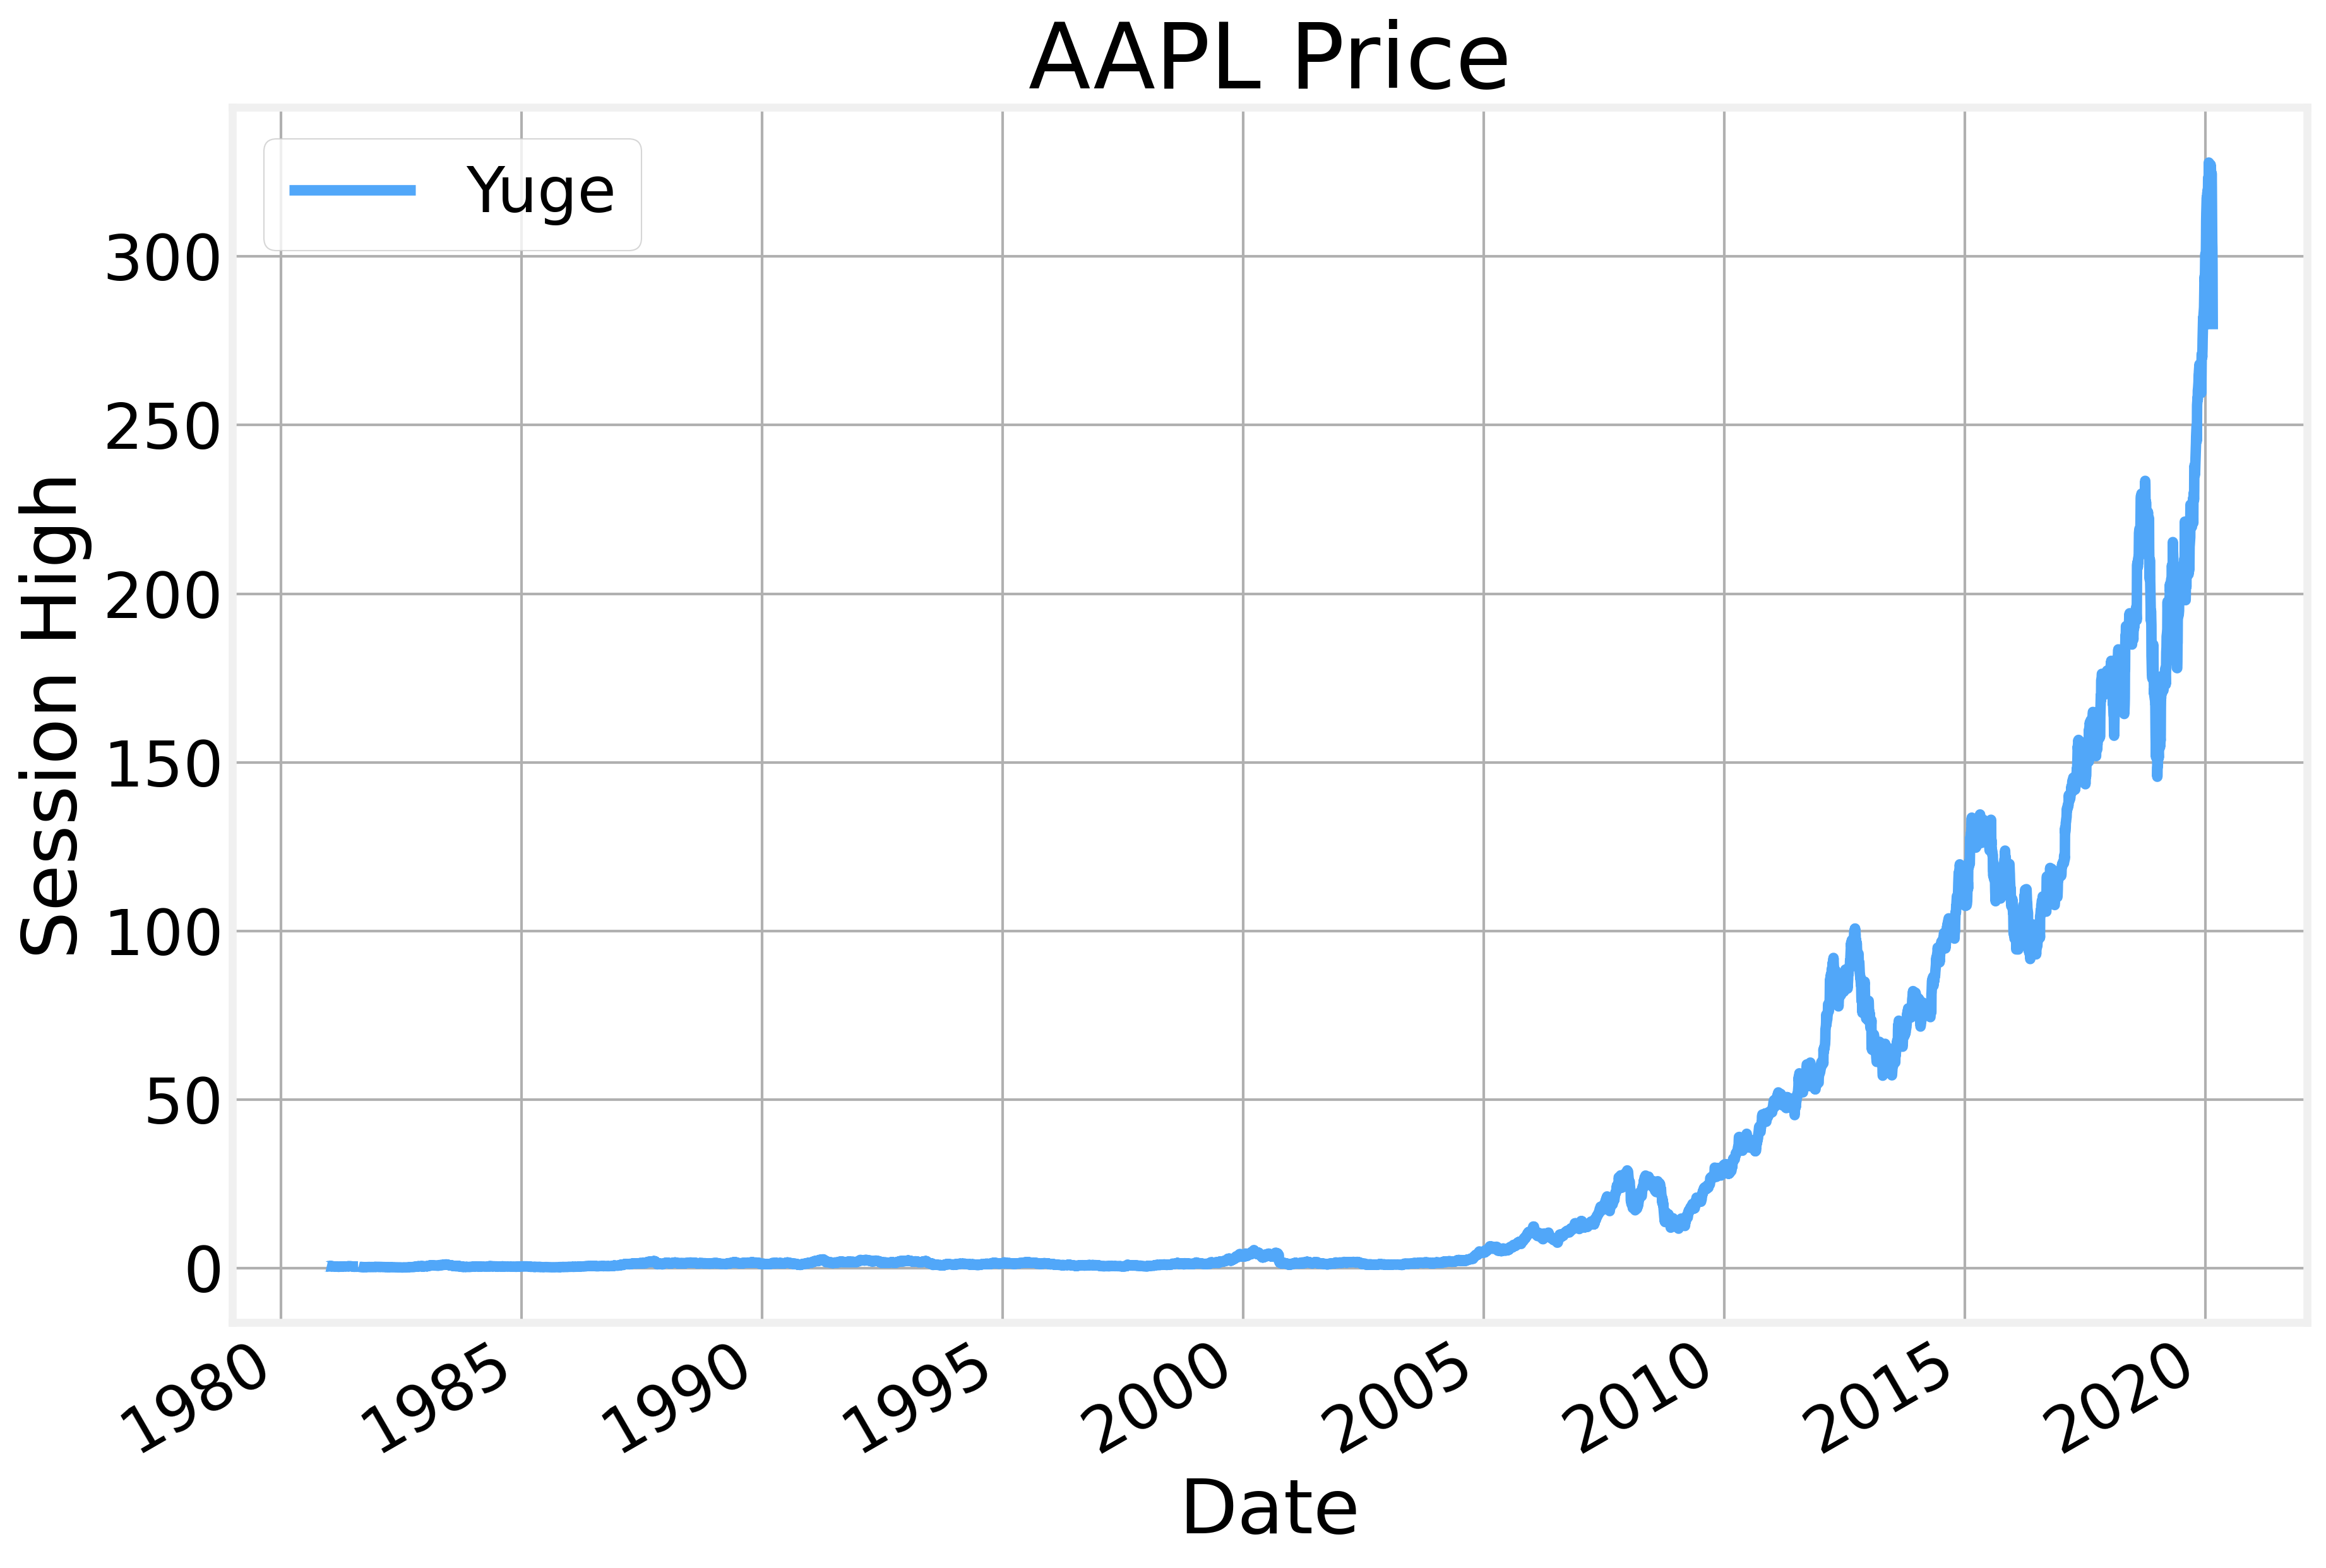

In [18]:
ax = data.plot(y='High')
ax.set_ylabel('Session High')
ax.set_xlabel('Date')
ax.set_title('AAPL Price')
ax.legend(['Yuge'])

## Linear Regression

Let us load a simple data set. This is one of the Anscombe quartet datasets that is known to have a slope of 0.5 and an zero-intercept at 3

In [19]:
data = pd.read_csv('data/Anscombe1.dat', header=None, sep=' ')

Performing the fit is simple

In [20]:
lm = LinearRegression()
lm.fit(data[[0]], data[[1]])

LinearRegression()

We can now obtain the coefficients of the fit. As this is a simple 2D plot, we have just one coeficient, the slope

In [21]:
lm.coef_

array([[0.50009091]])

The zero-intercept is also easily accessible

In [22]:
lm.intercept_

array([3.00009091])

Text(0, 0.5, 'Y')

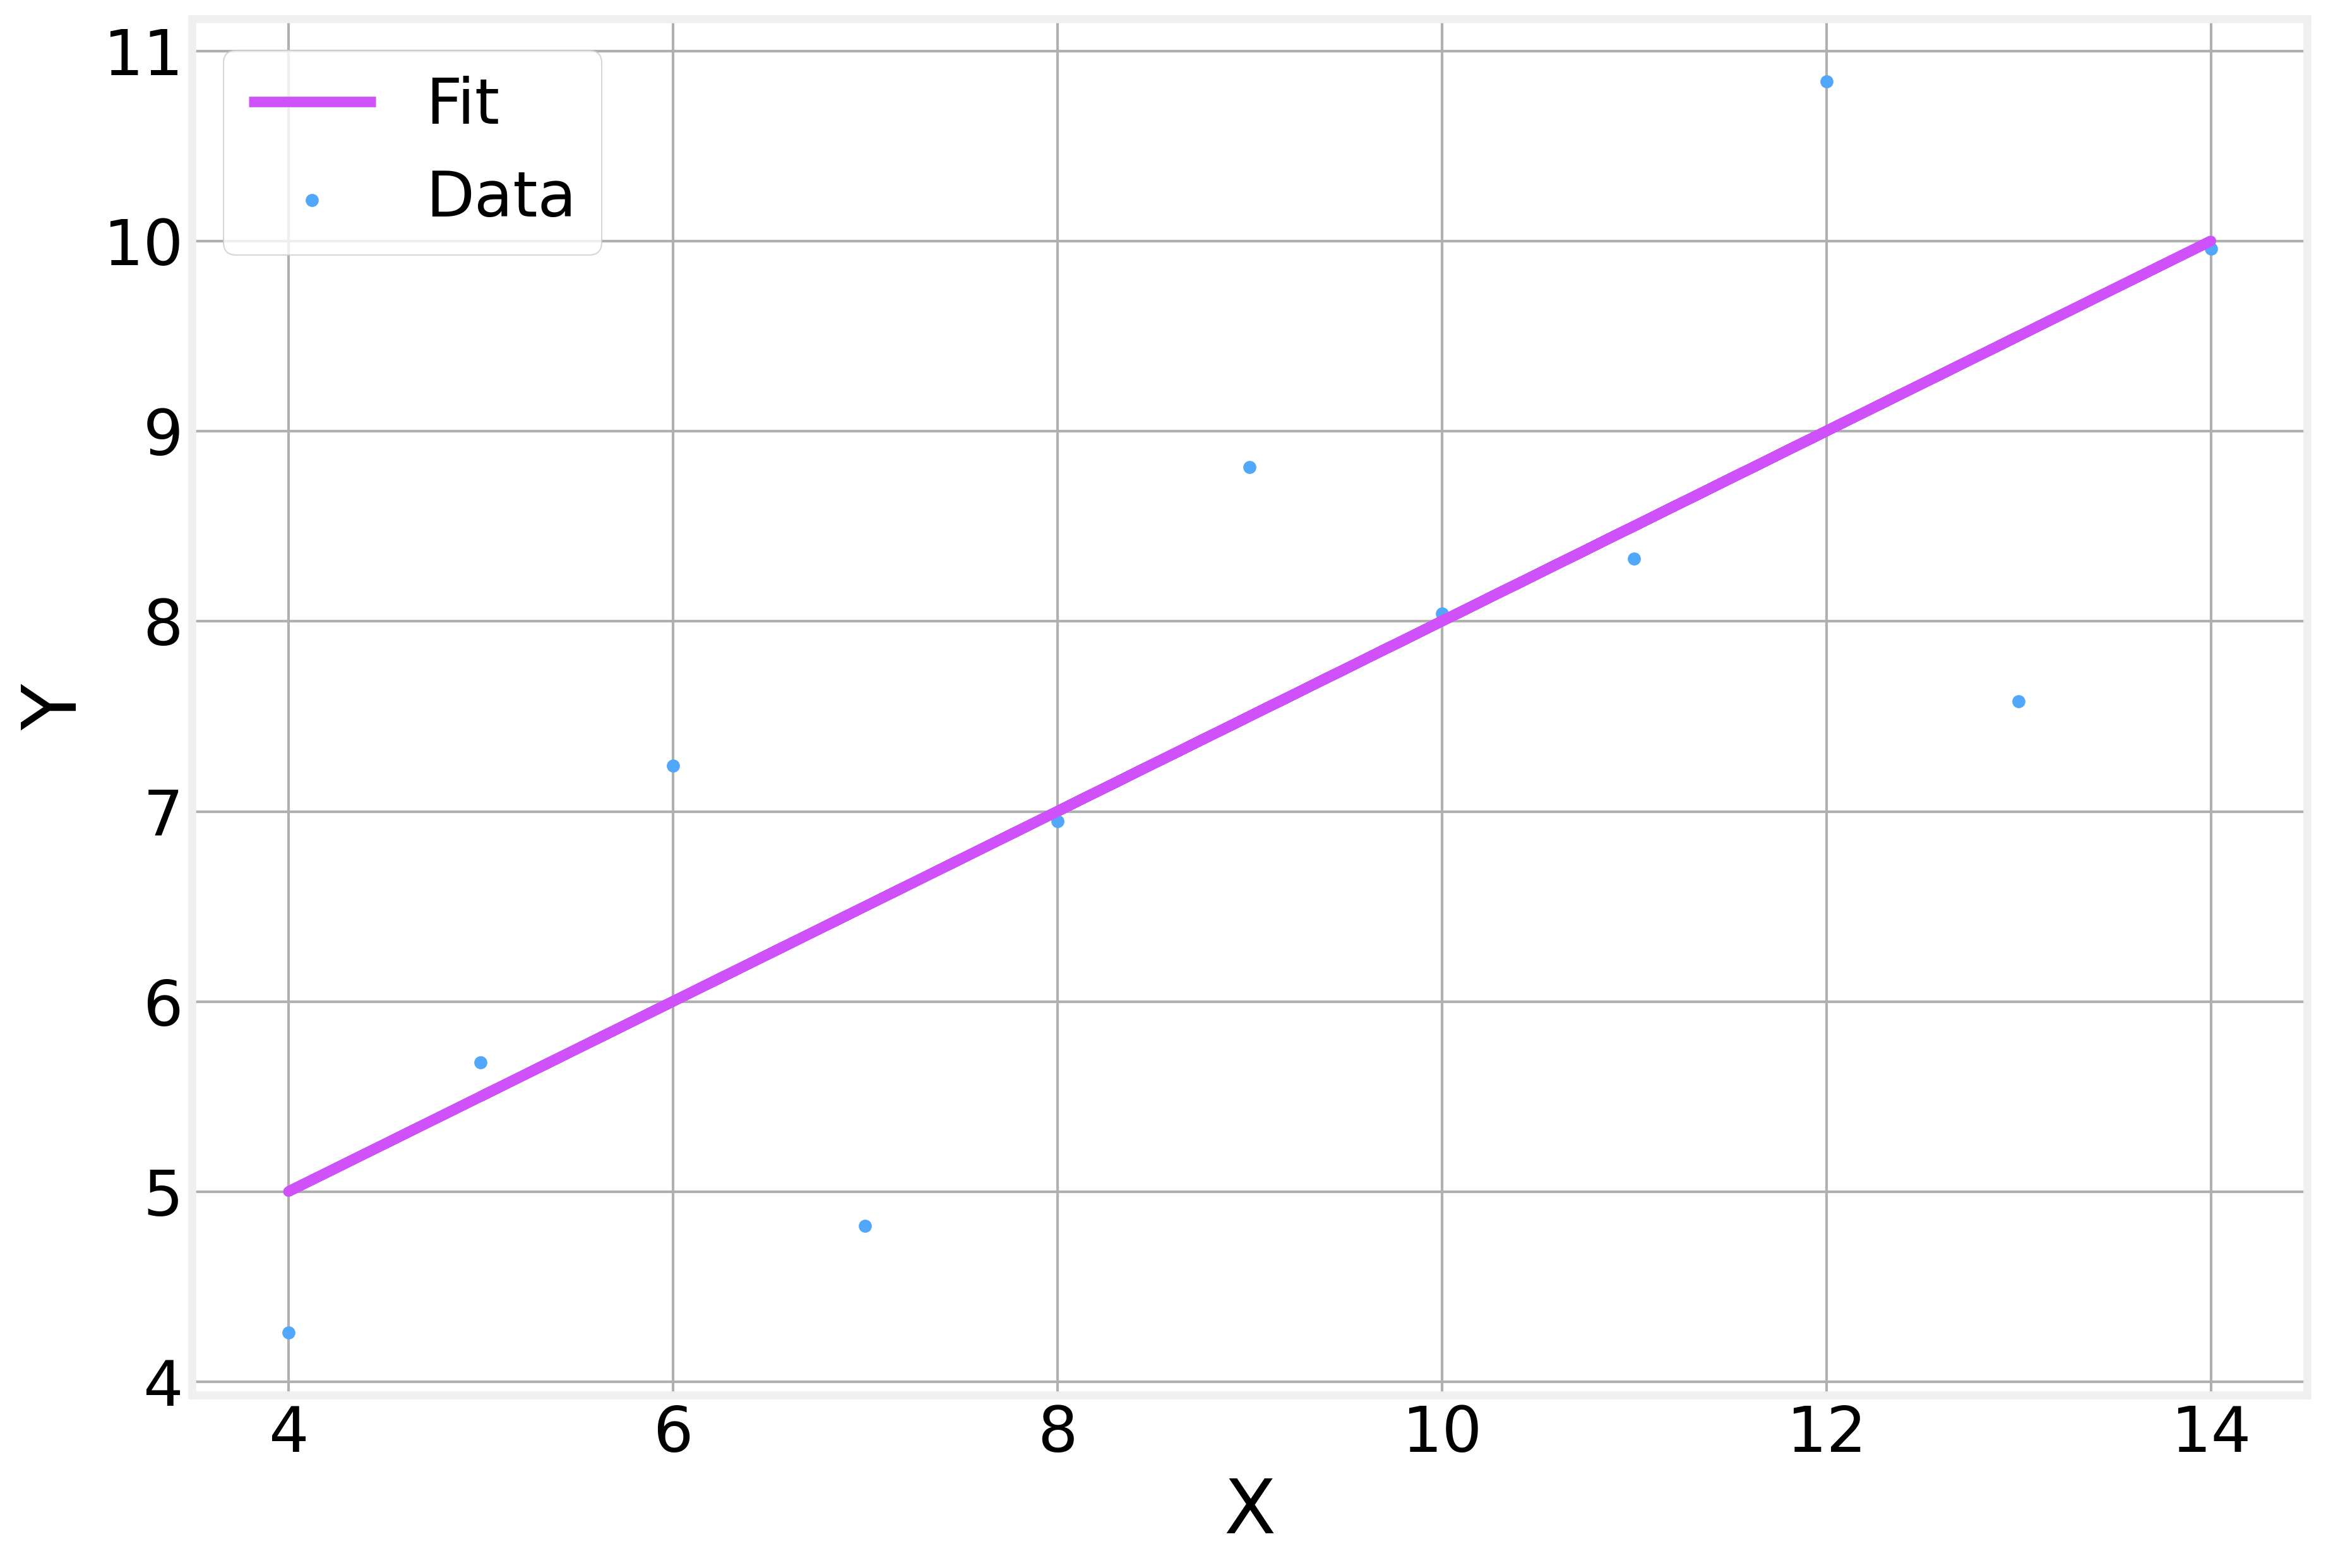

In [23]:
y_ = lm.predict(data[[0]])

ax = data.plot.scatter(x=0, y=1)
ax.plot(data[0], y_, c=colors[1])
ax.legend(['Fit', 'Data'])
ax.set_xlabel('X')
ax.set_ylabel('Y')

## Curve Fitting

As an example of arbitrary curve fitting, we will generate a noisy dataset following an exponential function

In [24]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

Within the [0, 4] interval

In [25]:
xdata = np.linspace(0, 4, 50)

We compute the noisy values for a specific set of parameters

In [26]:
y = func(xdata, 2.5, 1.3, 0.5)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

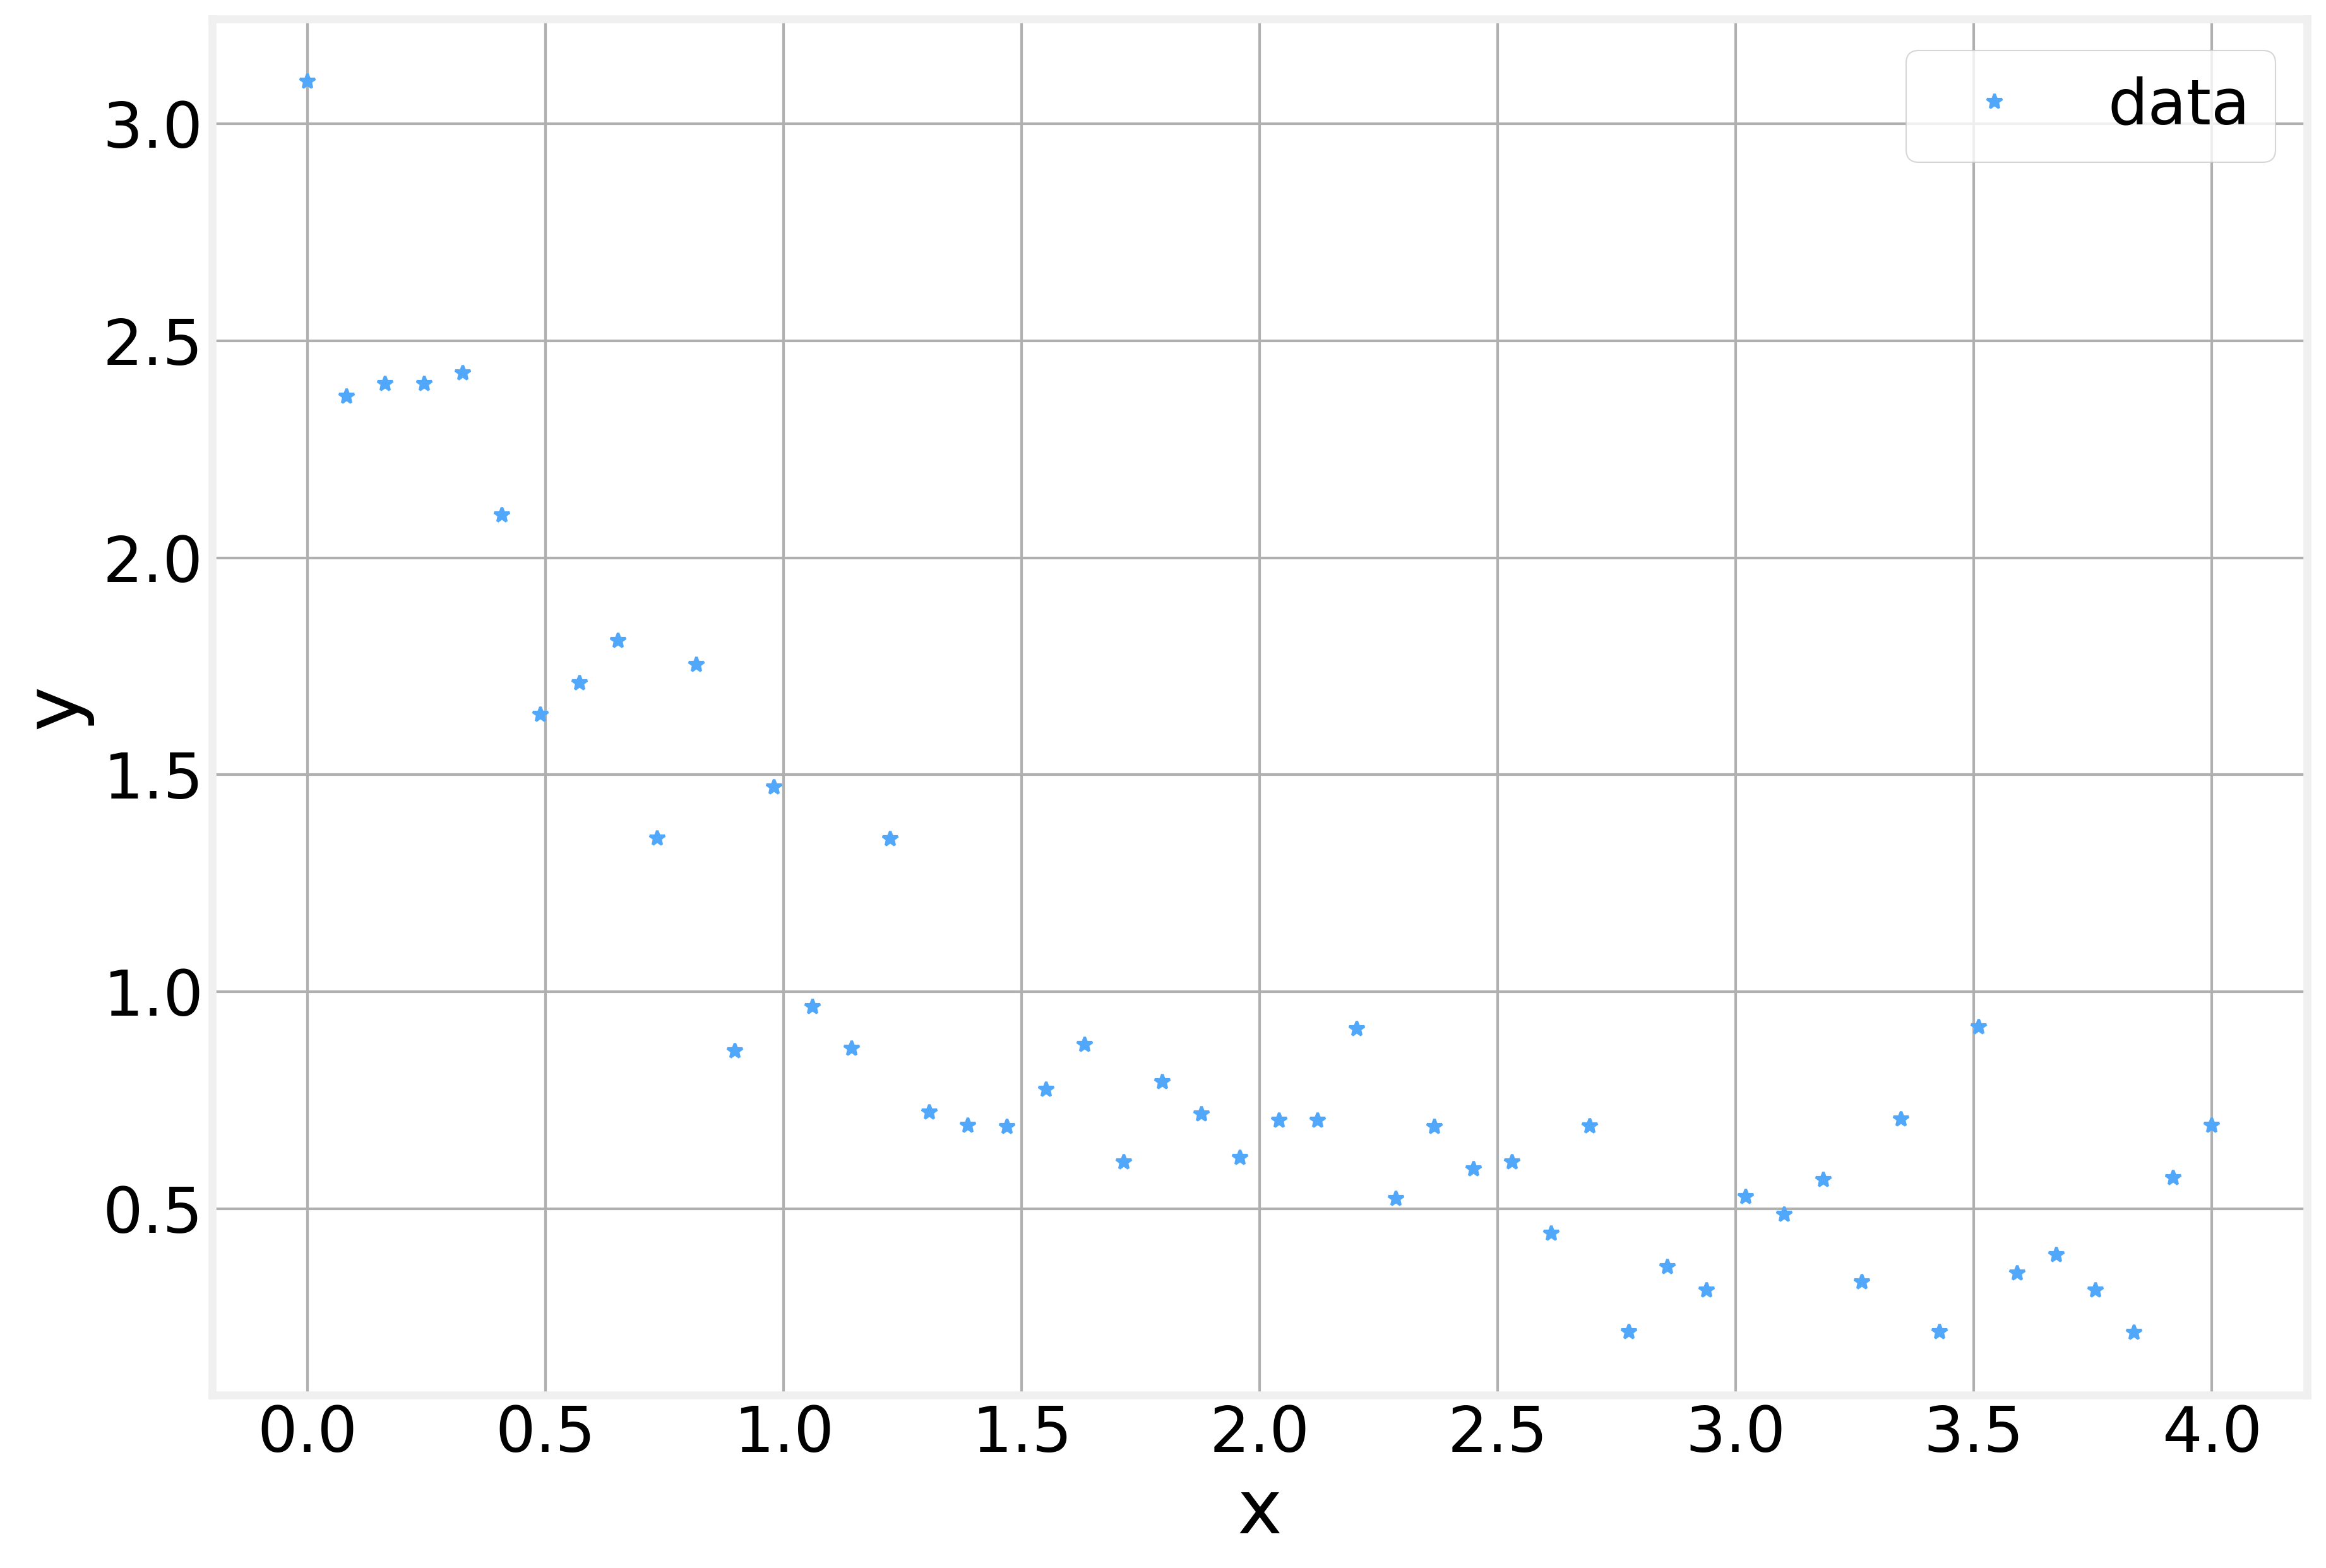

In [27]:
plt.plot(xdata, ydata, '*', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

To perform the fit we just need to call __curve_fit__ with the function and the x and y values

In [28]:
coef, covariance = curve_fit(func, xdata, ydata)

And extract the coefficients

In [29]:
coef

array([2.53357945, 1.19981533, 0.42339366])

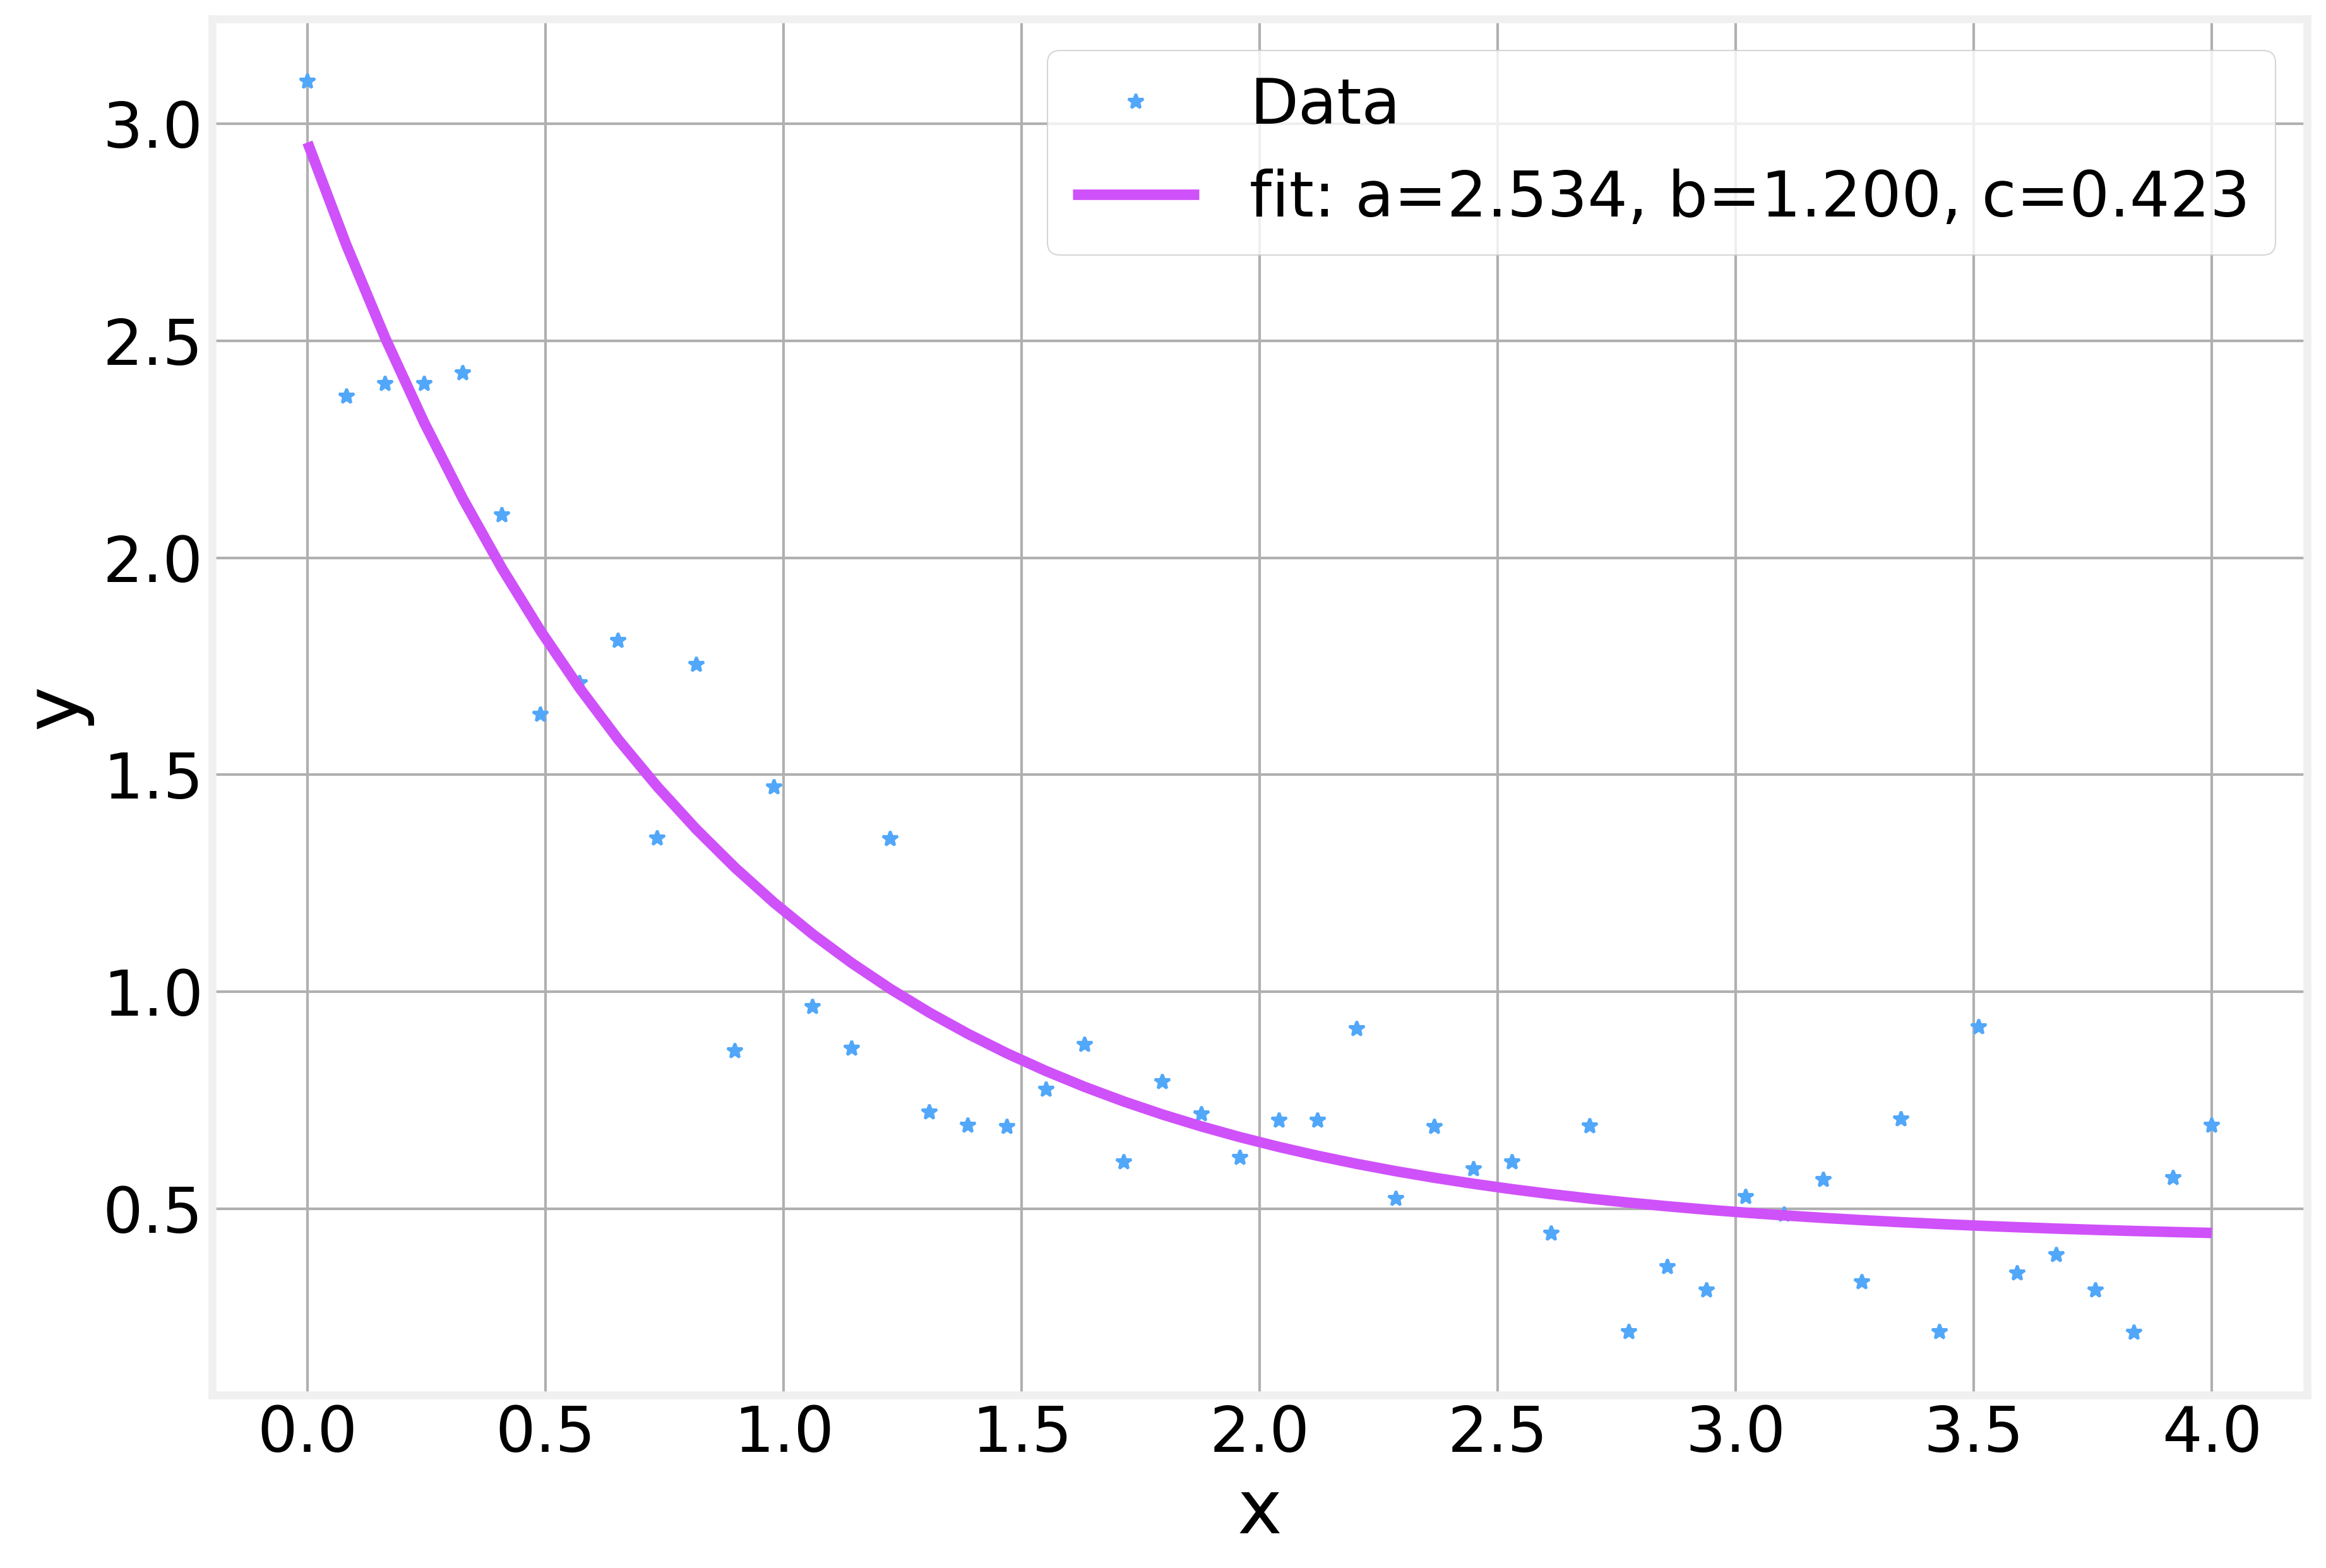

In [30]:
plt.plot(xdata, ydata, '*', label='Data')
plt.plot(xdata, func(xdata, *coef), '-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(coef))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>